In [1]:
import warnings

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np
import seaborn as sns

from sklearn.pipeline import Pipeline

from preprocess_sunshine import sunshine_transformer
from preprocess_raintomorrow import raintomorrow_transformer
from preprocess_date import preprocess_date_transformer
from preprocess_temp import preprocess_temp
from preprocess_rainfall_raintoday import rainfall_raintoday_transformer
from preprocess_wind import wind_speed_transformer, wind_dir_transformer
from preprocess_humidity_pressure import VoisinageNAImputer
from preprocess_evaporation import evaporation_transformer
from preprocess_cloud import cloud_transformer



from sklearn.preprocessing import MinMaxScaler

from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import IsotonicRegression

from sklearn.linear_model import LogisticRegression

from sklearn.calibration import calibration_curve
from sklearn.model_selection import train_test_split,  GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, f1_score, brier_score_loss, roc_curve, roc_auc_score, precision_recall_curve, recall_score, precision_score, log_loss


In [65]:

warnings.filterwarnings('ignore')

df = pd.read_csv('../data/weatherAUS.csv')

city = 'Perth'

df = df[df['Location'].isin([city])]

# print(df.isna().sum()/len(df))

columns_to_drop = [col for col in df.columns if df[col].isna().mean() > 0.30]

# print('colonne drop', columns_to_drop)
# print('colonne du dataframe', df.columns)

transformers = []

if 'RainTomorrow' not in columns_to_drop:
    transformers.append(('raintomorrow_transformer', raintomorrow_transformer()))

if 'Evaporation' not in columns_to_drop:
    transformers.append(('evaporation_transformer', evaporation_transformer()))
if 'Sunshine' not in columns_to_drop:
    transformers.append(('sunshine_transformer', sunshine_transformer()))

if 'Date' not in columns_to_drop:
    transformers.append(('date_transformer', preprocess_date_transformer()))
for temp_col in ['MinTemp', 'MaxTemp', 'Temp9am', 'Temp3pm']:
    if temp_col not in columns_to_drop:
        transformers.append((f'{temp_col.lower()}_transformer', preprocess_temp(col_select=temp_col)))
for wind_col in ['WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm']:
    if wind_col not in columns_to_drop:
        transformers.append((f'{wind_col.lower()}_transformer', wind_speed_transformer(col_select=wind_col)))
for wind_dir_col in ['WindGustDir', 'WindDir9am', 'WindDir3pm']:
    if wind_dir_col not in columns_to_drop:
        transformers.append((f'{wind_dir_col.lower()}_transformer', wind_dir_transformer(col_select=wind_dir_col)))
if 'Rainfall' not in columns_to_drop:
    transformers.append(('rainfall_transformer', rainfall_raintoday_transformer(city=city)))
for humidity_col in ['Humidity9am', 'Humidity3pm']:
    if humidity_col not in columns_to_drop:
        transformers.append((f'{humidity_col.lower()}_imputer', VoisinageNAImputer(column=humidity_col)))
for pressure_col in ['Pressure9am', 'Pressure3pm']:
    if pressure_col not in columns_to_drop:
        transformers.append((f'{pressure_col.lower()}_imputer', VoisinageNAImputer(column=pressure_col)))

for cloud_col in ['Cloud9am', 'Cloud3pm']:
    if cloud_col not in columns_to_drop:
        transformers.append((f'{cloud_col.lower()}_transformer', cloud_transformer(col_select=cloud_col)))

df_transformed = Pipeline(transformers).fit_transform(df)

df = df.drop(columns = ['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm'] + columns_to_drop)
df = df.set_index('Date')

print('avant', df.shape)
df.dropna(inplace = True)
print('apres', df.shape)

avant (3193, 144)
apres (3173, 144)


In [66]:
pd.set_option('display.max_rows', None)
df.isna().sum()

MinTemp                 0
MaxTemp                 0
Rainfall                0
Evaporation             0
Sunshine                0
WindGustSpeed           0
WindSpeed9am            0
WindSpeed3pm            0
Humidity9am             0
Humidity3pm             0
Pressure9am             0
Pressure3pm             0
Cloud9am                0
Cloud3pm                0
Temp9am                 0
Temp3pm                 0
RainToday               0
RainTomorrow            0
Evaporation_mean_7      0
Evaporation_std_7       0
Evaporation_max_7       0
Evaporation_min_7       0
Evaporation_mean_5      0
Evaporation_std_5       0
Evaporation_max_5       0
Evaporation_min_5       0
Evaporation_mean_3      0
Evaporation_std_3       0
Evaporation_max_3       0
Evaporation_min_3       0
Evaporation_diff        0
Sunshine_mean_7         0
Sunshine_std_7          0
Sunshine_max_7          0
Sunshine_min_7          0
Sunshine_mean_5         0
Sunshine_std_5          0
Sunshine_max_5          0
Sunshine_min

In [67]:
X = df.drop(columns='RainTomorrow')
y = df['RainTomorrow']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

scaler = MinMaxScaler(feature_range=(-1, 1))
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

poids = y_train.value_counts(normalize = True)


model = LogisticRegression(verbose = 1,
                           C = 1,
                           max_iter = 1000,
                           penalty = 'l1',
                           solver = 'liblinear',
                           intercept_scaling = 0.1,
                           tol = 0.01
                        )


model.fit(X_train_scaled, y_train)


prob = model.predict_proba(X_test_scaled)

y_pred_prob1 = model.predict_proba(X_test_scaled)[:, 1]

if y_train.value_counts(normalize = True)[1] < 0.15:
        threshold = 0.165
if y_train.value_counts(normalize = True)[1] > 0.30:
    threshold = 0.85
else:
    precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob1)
    diff = abs(precision - recall)
    threshold = thresholds[diff.argmin()]

print('threshold :', threshold)

y_pred = (y_pred_prob1 > threshold).astype(int)


print('Accuracy score: ', model.score(X_test_scaled, y_test))
print('F1 score: ', f1_score(y_test, y_pred))
print('ROC AUC score: ', roc_auc_score(y_test, y_pred))
print('Brier score: ', brier_score_loss(y_test, y_pred), '\n\n')

print(confusion_matrix(y_test, y_pred), '\n\n')
classif = classification_report(y_test, y_pred)
print(classif)

[LibLinear]iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 6
iter   6  #CD cycles 1
iter   7  #CD cycles 17
optimization finished, #iter = 7
Objective value = 514.493388
#nonzeros/#features = 89/144
threshold : 0.3953814237937631
Accuracy score:  0.8954659949622166
F1 score:  0.7601246105919003
ROC AUC score:  0.84886618978933
Brier score:  0.09697732997481108 


[[595  38]
 [ 39 122]] 


              precision    recall  f1-score   support

         0.0       0.94      0.94      0.94       633
         1.0       0.76      0.76      0.76       161

    accuracy                           0.90       794
   macro avg       0.85      0.85      0.85       794
weighted avg       0.90      0.90      0.90       794



In [68]:
print(X_train.isna().sum())

MinTemp                 0
MaxTemp                 0
Rainfall                0
Evaporation             0
Sunshine                0
WindGustSpeed           0
WindSpeed9am            0
WindSpeed3pm            0
Humidity9am             0
Humidity3pm             0
Pressure9am             0
Pressure3pm             0
Cloud9am                0
Cloud3pm                0
Temp9am                 0
Temp3pm                 0
RainToday               0
Evaporation_mean_7      0
Evaporation_std_7       0
Evaporation_max_7       0
Evaporation_min_7       0
Evaporation_mean_5      0
Evaporation_std_5       0
Evaporation_max_5       0
Evaporation_min_5       0
Evaporation_mean_3      0
Evaporation_std_3       0
Evaporation_max_3       0
Evaporation_min_3       0
Evaporation_diff        0
Sunshine_mean_7         0
Sunshine_std_7          0
Sunshine_max_7          0
Sunshine_min_7          0
Sunshine_mean_5         0
Sunshine_std_5          0
Sunshine_max_5          0
Sunshine_min_5          0
Sunshine_mea

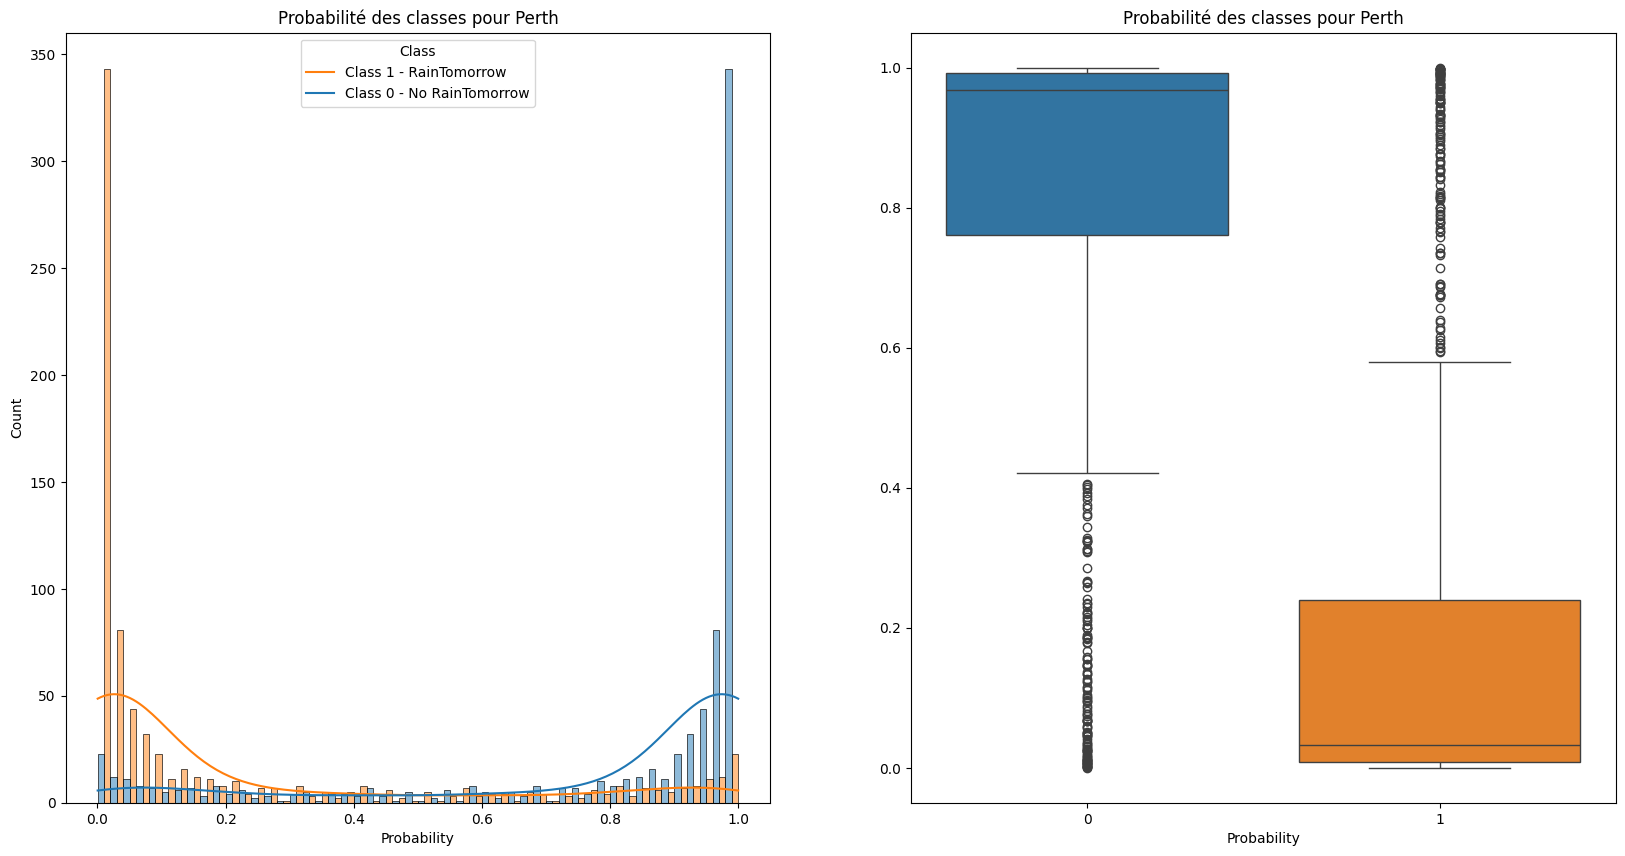

In [14]:
# y_pred_prob = model.predict_proba(X_test_scaled)
# probs_inverted = 1 - probs_scaled
# probs_normalized_1 = probs_inverted / np.max(probs_inverted)


plt.figure(figsize = (20, 10))
plt.subplot(121)
sns.histplot(prob, bins = 50, kde = True,
             stat = 'count', multiple = 'dodge',
             color = ['yellow', 'blue'])
plt.xlabel('Probability')
plt.legend(title='Class', labels=['Class 1 - RainTomorrow', 'Class 0 - No RainTomorrow'], loc='upper center')
plt.title(f'Probabilité des classes pour {city}')

plt.subplot(122)
sns.boxplot(prob)
plt.xlabel('Probability')
plt.title(f'Probabilité des classes pour {city}')
plt.show()
plt.show()


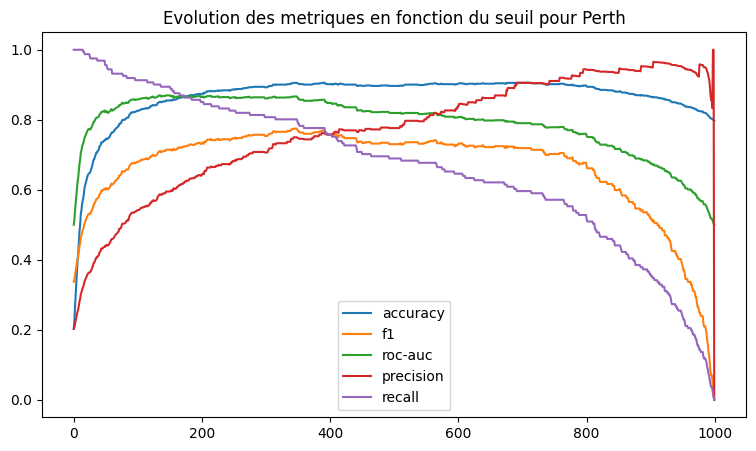

In [15]:
f1_1 = []
roc_1 = []
precision1 = []
recall1 = []
accuracy = []

for i in np.linspace(0, 1, 1000):

    seuil = i

    y_pred = (y_pred_prob1 > i).astype("int32")
    accuracy.append(accuracy_score(y_test, y_pred))
    f1_1.append(f1_score(y_test, y_pred))
    roc_1.append(roc_auc_score(y_test, y_pred))
    precision1.append(precision_score(y_test, y_pred))
    recall1.append(recall_score(y_test, y_pred))

plt.figure(figsize = (20, 5))

plt.subplot(121)
plt.plot(accuracy, label = 'accuracy')
plt.plot(f1_1, label = 'f1')
plt.plot(roc_1, label = 'roc-auc')
plt.plot(precision1, label = 'precision')
plt.plot(recall1, label = 'recall')
plt.title(f'Evolution des metriques en fonction du seuil pour {city}')
plt.legend()

plt.show()

In [16]:
df = pd.read_csv('../data/weatherAUS.csv')


print(df['Location'].unique())

['Albury' 'BadgerysCreek' 'Cobar' 'CoffsHarbour' 'Moree' 'Newcastle'
 'NorahHead' 'NorfolkIsland' 'Penrith' 'Richmond' 'Sydney' 'SydneyAirport'
 'WaggaWagga' 'Williamtown' 'Wollongong' 'Canberra' 'Tuggeranong'
 'MountGinini' 'Ballarat' 'Bendigo' 'Sale' 'MelbourneAirport' 'Melbourne'
 'Mildura' 'Nhil' 'Portland' 'Watsonia' 'Dartmoor' 'Brisbane' 'Cairns'
 'GoldCoast' 'Townsville' 'Adelaide' 'MountGambier' 'Nuriootpa' 'Woomera'
 'Albany' 'Witchcliffe' 'PearceRAAF' 'PerthAirport' 'Perth' 'SalmonGums'
 'Walpole' 'Hobart' 'Launceston' 'AliceSprings' 'Darwin' 'Katherine'
 'Uluru']


{'0.0': {'precision': 0.9057851239669421, 'recall': 0.9072847682119205, 'f1-score': 0.9065343258891646, 'support': 604.0}, '1.0': {'precision': 0.68, 'recall': 0.6761363636363636, 'f1-score': 0.6780626780626781, 'support': 176.0}, 'accuracy': 0.8551282051282051, 'macro avg': {'precision': 0.792892561983471, 'recall': 0.7917105659241421, 'f1-score': 0.7922985019759213, 'support': 780.0}, 'weighted avg': {'precision': 0.8548387370205552, 'recall': 0.8551282051282051, 'f1-score': 0.8549817489437009, 'support': 780.0}}


In [60]:

df_1 = pd.read_csv('../data/weatherAUS.csv')

list_city = []
list_accuracy = []
list_f1 = []
list_recall = []
list_precision = []
list_roc = []

precision_0 = []
recall_0 = []
f1_0 = []
support_0 = []
precision_1 = []
recall_1 = []
f1_1 = []
support_1 = []

macro_avg_precision = []
macro_avg_recall = []
macro_avg_f1 = []

weighted_avg_precision = []
weighted_avg_recall = []
weighted_avg_f1 = []





# print(df['Location'].unique(), end = '\n\n')

# while True:

#     city = input('Quelle ville choisissez vous ?\n ---->\n\n').capitalize()

#     if city in df['Location'].unique():
#         break  # La ville est valide, on sort de la boucle
#     else:
#         print(f"La ville '{city}' n'est pas dans la liste. \n\n Veuillez choisir une ville parmi celles disponibles.")

city = df_1['Location'].unique()
print(city)
for i in city:
    print('la ville -----------------', i)

    df = df_1[df_1['Location'].isin([i])]

    columns_to_drop = [col for col in df.columns if df[col].isna().mean() > 0.30]

    # print('colonne drop', columns_to_drop)
    # print('colonne du dataframe', df.columns)

    transformers = []
    if 'RainTomorrow' not in columns_to_drop:
        transformers.append(('raintomorrow_transformer', raintomorrow_transformer()))
    if 'Evaporation' not in columns_to_drop:
        transformers.append(('evaporation_transformer', evaporation_transformer()))
    if 'Sunshine' not in columns_to_drop:
        transformers.append(('sunshine_transformer', sunshine_transformer()))
    if 'Date' not in columns_to_drop:
        transformers.append(('date_transformer', preprocess_date_transformer()))
    for temp_col in ['MinTemp', 'MaxTemp', 'Temp9am', 'Temp3pm']:
        if temp_col not in columns_to_drop:
            transformers.append((f'{temp_col.lower()}_transformer', preprocess_temp(col_select=temp_col)))
    for wind_col in ['WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm']:
        if wind_col not in columns_to_drop:
            transformers.append((f'{wind_col.lower()}_transformer', wind_speed_transformer(col_select=wind_col)))
    for wind_dir_col in ['WindGustDir', 'WindDir9am', 'WindDir3pm']:
        if wind_dir_col not in columns_to_drop:
            transformers.append((f'{wind_dir_col.lower()}_transformer', wind_dir_transformer(col_select=wind_dir_col)))
    if 'Rainfall' not in columns_to_drop:
        transformers.append(('rainfall_transformer', rainfall_raintoday_transformer(city=city)))
    for humidity_col in ['Humidity9am', 'Humidity3pm']:
        if humidity_col not in columns_to_drop:
            transformers.append((f'{humidity_col.lower()}_imputer', VoisinageNAImputer(column=humidity_col)))
    for pressure_col in ['Pressure9am', 'Pressure3pm']:
        if pressure_col not in columns_to_drop:
            transformers.append((f'{pressure_col.lower()}_imputer', VoisinageNAImputer(column=pressure_col)))
    for cloud_col in ['Cloud9am', 'Cloud3pm']:
        if cloud_col not in columns_to_drop:
            transformers.append((f'{cloud_col.lower()}_transformer', cloud_transformer(col_select=cloud_col)))



    df_transformed = Pipeline(transformers).fit_transform(df)

    df = df.drop(columns = ['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm'] + columns_to_drop)
    df = df.set_index('Date')
    print(df.columns)

    df.dropna(inplace = True)


    X = df.drop(columns = 'RainTomorrow')
    y = df['RainTomorrow']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

    scaler = MinMaxScaler(feature_range = (-1, 1))
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)


    model = LogisticRegression(verbose = 1, C = 1, max_iter = 10000, penalty = 'l1',
                               solver = 'liblinear',
                               intercept_scaling = 0.1, l1_ratio = 0.5, tol = 0.01,)


    model.fit(X_train_scaled, y_train)

    print(y_train.value_counts(normalize = True))
    print(y_train.value_counts())

    prob = model.predict_proba(X_test_scaled)

    y_pred_prob1 = model.predict_proba(X_test_scaled)[:, 1]

    if y_train.value_counts(normalize = True)[1] < 0.15:
            threshold = 0.165
    if y_train.value_counts(normalize = True)[1] > 0.30:
        threshold = 0.85
    else:
        precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob1)
        diff = abs(precision - recall)
        threshold = thresholds[diff.argmin()]


    y_pred = (y_pred_prob1 > threshold).astype(int)

    list_city.append(i)

    list_accuracy.append(model.score(X_test_scaled, y_test))
    list_f1.append(f1_score(y_test, y_pred))
    list_roc.append(roc_auc_score(y_test, y_pred))
    list_precision.append(precision_score(y_test, y_pred))
    list_recall.append(recall_score(y_test, y_pred))

    classif = classification_report(y_test, y_pred, output_dict = True)

    precision_0.append(classif['0.0']['precision'])
    recall_0.append(classif['0.0']['recall'])
    f1_0.append(classif['0.0']['f1-score'])
    support_0.append(classif['0.0']['support'])

    precision_1.append(classif['1.0']['precision'])
    recall_1.append(classif['1.0']['recall'])
    f1_1.append(classif['1.0']['f1-score'])
    support_1.append(classif['1.0']['support'])

    macro_avg_precision.append(classif['macro avg']['precision'])
    macro_avg_recall.append(classif['macro avg']['recall'])
    macro_avg_f1.append(classif['macro avg']['f1-score'])

    weighted_avg_precision.append(classif['weighted avg']['precision'])
    weighted_avg_recall.append(classif['weighted avg']['recall'])
    weighted_avg_f1.append(classif['weighted avg']['f1-score'])


['Albury' 'BadgerysCreek' 'Cobar' 'CoffsHarbour' 'Moree' 'Newcastle'
 'NorahHead' 'NorfolkIsland' 'Penrith' 'Richmond' 'Sydney' 'SydneyAirport'
 'WaggaWagga' 'Williamtown' 'Wollongong' 'Canberra' 'Tuggeranong'
 'MountGinini' 'Ballarat' 'Bendigo' 'Sale' 'MelbourneAirport' 'Melbourne'
 'Mildura' 'Nhil' 'Portland' 'Watsonia' 'Dartmoor' 'Brisbane' 'Cairns'
 'GoldCoast' 'Townsville' 'Adelaide' 'MountGambier' 'Nuriootpa' 'Woomera'
 'Albany' 'Witchcliffe' 'PearceRAAF' 'PerthAirport' 'Perth' 'SalmonGums'
 'Walpole' 'Hobart' 'Launceston' 'AliceSprings' 'Darwin' 'Katherine'
 'Uluru']
la ville ----------------- Albury
Pas de station à moins de 50 km de Albury
Index(['MinTemp', 'MaxTemp', 'Rainfall', 'WindGustSpeed', 'WindSpeed9am',
       'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am',
       'Pressure3pm',
       ...
       'WindSpeed3pm_std_3', 'WindSpeed3pm_max_3', 'WindSpeed3pm_min_3',
       'WindSpeed3pm_diff', 'WindGustDir_cos', 'WindGustDir_sin',
       'WindDir9am_cos', 'Win

{'0.0': {'precision': 0.9057851239669421, 'recall': 0.9072847682119205, 'f1-score': 0.9065343258891646, 'support': 604.0}, '1.0': {'precision': 0.68, 'recall': 0.6761363636363636, 'f1-score': 0.6780626780626781, 'support': 176.0}, 'accuracy': 0.8551282051282051, 'macro avg': {'precision': 0.792892561983471, 'recall': 0.7917105659241421, 'f1-score': 0.7922985019759213, 'support': 780.0}, 'weighted avg': {'precision': 0.8548387370205552, 'recall': 0.8551282051282051, 'f1-score': 0.8549817489437009, 'support': 780.0}}

In [61]:
df_global = pd.DataFrame({
    'location' : list_city,
    'accuracy' : list_accuracy,
    'f1': list_f1,
    'roc-auc' : list_roc,
    'precision' : list_precision,
    'recall' : list_recall,
    'precision_0' : precision_0,
    'recall_0' : recall_0,
    'f1_0' : f1_0,
    'support_0' : support_0,
    'precision_1' : precision_1,
    'recall_1' : recall_1,
    'f1_1' : f1_1,
    'support_1' : support_1,
    'macro_avg_precision' : macro_avg_precision,
    'macro_avg_recall' : macro_avg_recall,
    'macro_avg_f1' : macro_avg_f1,
    'weighted_avg_precision' : weighted_avg_precision,
    'weighted_avg_recall' : weighted_avg_recall,
    'weighted_avg_f1' : weighted_avg_f1
    }
)

df_global.set_index('location', inplace = True)


df_global.to_csv('../data_saved/first_result_evap.csv')

In [62]:
df_global.mean(axis = 0)

accuracy                    0.858628
f1                          0.616349
roc-auc                     0.756526
precision                   0.698546
recall                      0.589620
precision_0                 0.880829
recall_0                    0.923432
f1_0                        0.899136
support_0                 407.673469
precision_1                 0.698546
recall_1                    0.589620
f1_1                        0.616349
support_1                 119.306122
macro_avg_precision         0.789687
macro_avg_recall            0.756526
macro_avg_f1                0.757742
weighted_avg_precision      0.848742
weighted_avg_recall         0.842604
weighted_avg_f1             0.834631
dtype: float64

In [63]:
df_global

,accuracy,f1,roc-auc,precision,recall,precision_0,recall_0,f1_0,support_0,precision_1,recall_1,f1_1,support_1,macro_avg_precision,macro_avg_recall,macro_avg_f1,weighted_avg_precision,weighted_avg_recall,weighted_avg_f1
location,,,,,,,,,,,,,,,,,,,
Albury,0.860972,0.641975,0.774409,0.644628,0.639344,0.907563,0.909474,0.908517,475.0,0.644628,0.639344,0.641975,122.0,0.776096,0.774409,0.775246,0.853831,0.854271,0.854048
BadgerysCreek,0.873162,0.600939,0.751011,0.603774,0.598131,0.901826,0.903890,0.902857,437.0,0.603774,0.598131,0.600939,107.0,0.752800,0.751011,0.751898,0.843202,0.843750,0.843473
Cobar,0.913828,0.642336,0.790934,0.647059,0.637681,0.941995,0.944186,0.943089,430.0,0.647059,0.637681,0.642336,69.0,0.794527,0.790934,0.792713,0.901213,0.901804,0.901502
CoffsHarbour,0.791155,0.290909,0.579010,0.827586,0.176471,0.703704,0.981550,0.819723,271.0,0.827586,0.176471,0.290909,136.0,0.765645,0.579010,0.555316,0.745099,0.712531,0.643018
Moree,0.917031,0.721805,0.835191,0.727273,0.716418,0.951531,0.953964,0.952746,391.0,0.727273,0.716418,0.721805,67.0,0.839402,0.835191,0.837275,0.918724,0.919214,0.918962
Newcastle,0.806510,0.560886,0.708668,0.562963,0.558824,0.856459,0.858513,0.857485,417.0,0.562963,0.558824,0.560886,136.0,0.709711,0.708668,0.709185,0.784279,0.784810,0.784542
NorahHead,0.794783,0.649842,0.757794,0.651899,0.647799,0.865707,0.867788,0.866747,416.0,0.651899,0.647799,0.649842,159.0,0.758803,0.757794,0.758294,0.806585,0.806957,0.806768
NorfolkIsland,0.824253,0.371681,0.610305,0.875000,0.235955,0.738964,0.984655,0.844298,391.0,0.875000,0.235955,0.371681,178.0,0.806982,0.610305,0.607990,0.781520,0.750439,0.696450
Penrith,0.891037,0.669604,0.792674,0.672566,0.666667,0.916667,0.918681,0.917673,455.0,0.672566,0.666667,0.669604,114.0,0.794617,0.792674,0.793638,0.867761,0.868190,0.867972


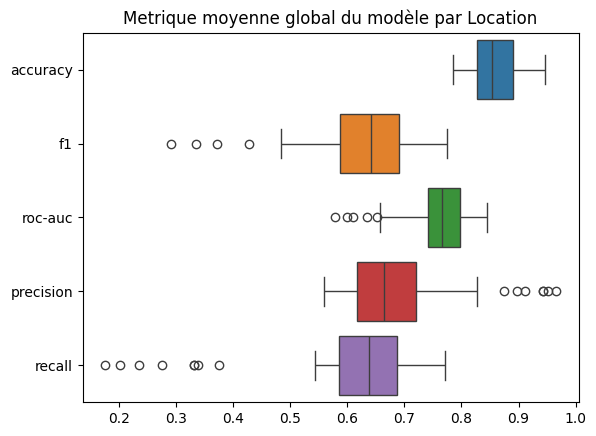

In [64]:
sns.boxplot(data = df_global[['accuracy', 'f1', 'roc-auc', 'precision', 'recall']], orient = 'h')
plt.title('Metrique moyenne global du modèle par Location')
plt.show()

In [49]:
df_global.columns

Index(['accuracy', 'f1', 'roc-auc', 'precision', 'recall', 'precision_0',
       'recall_0', 'f1_0', 'support_0', 'precision_1', 'recall_1', 'f1_1',
       'support_1', 'macro_avg_precision', 'macro_avg_recall', 'macro_avg_f1',
       'weighted_avg_precision', 'weighted_avg_recall', 'weighted_avg_f1'],
      dtype='object')

In [50]:
print(classif)

{'0.0': {'precision': 0.9714285714285714, 'recall': 0.9855072463768116, 'f1-score': 0.9784172661870504, 'support': 69.0}, '1.0': {'precision': 0.8, 'recall': 0.6666666666666666, 'f1-score': 0.7272727272727273, 'support': 6.0}, 'accuracy': 0.96, 'macro avg': {'precision': 0.8857142857142857, 'recall': 0.8260869565217391, 'f1-score': 0.8528449967298888, 'support': 75.0}, 'weighted avg': {'precision': 0.9577142857142856, 'recall': 0.96, 'f1-score': 0.9583257030739044, 'support': 75.0}}


In [51]:
print(df_global['precision_0'].mean())
print(df_global['recall_0'].mean())
print(df_global['f1_0'].mean())
print(df_global['support_0'].mean())

print(df_global['precision_1'].mean())
print(df_global['recall_1'].mean())
print(df_global['f1_1'].mean())
print(df_global['support_1'].mean())

print(df_global['accuracy'].mean())

print(df_global['macro_avg_precision'].mean())
print(df_global['macro_avg_recall'].mean())
print(df_global['macro_avg_f1'].mean())

print(df_global['weighted_avg_precision'].mean())
print(df_global['weighted_avg_recall'].mean())
print(df_global['weighted_avg_f1'].mean())


0.8822443101804245
0.9292161280007725
0.9028770727155149
102.16326530612245
0.7195498970185318
0.595498059982591
0.6317676236204823
29.959183673469386
0.8590006206410459
0.8008971035994781
0.7623570939916817
0.7673223481679984
0.85326256945691
0.8484939607530778
0.8405948530842237
